In [8]:
from matplotlib import pyplot as plt
import numpy as np
import random
from typing import Callable

MIN: int = 0
MAX: int = 4
BINS: int = 100
NUM_SAMPLES: int = 100000
N: int = 5

In [9]:
# Toy language model that returns a uniformly distributed random number
def model(num_samples) -> np.ndarray:
    return np.random.uniform(0, MAX, num_samples)

def histogram(output):
    hist, bins = np.histogram(output, bins=BINS, range=(MIN, MAX), density=False)
    probs = hist / np.sum(hist)
    return probs, bins

In [10]:
# The ground truth reward model. We assume that we have a preference for the number `mid`.
def reward_model_ground_truth(output) -> float:
    # R(x) = 5 - |2 - x|
    return 5 - np.abs(2 - output)

# Definition of the proxy reward model. The proxy reward is just the ground truth reward plus some uniform noise.
def reward_model_proxy(output) -> float:
    ground_truth_reward = reward_model_ground_truth(output)
    # Add noise = 2 when x ∈ [0, 0.01] or [3.99, 4]
    if (0 <= output <= 0.01) or (3.99 <= output <= 4):
        noise = 2
    else:
        noise = 0
    return ground_truth_reward + noise

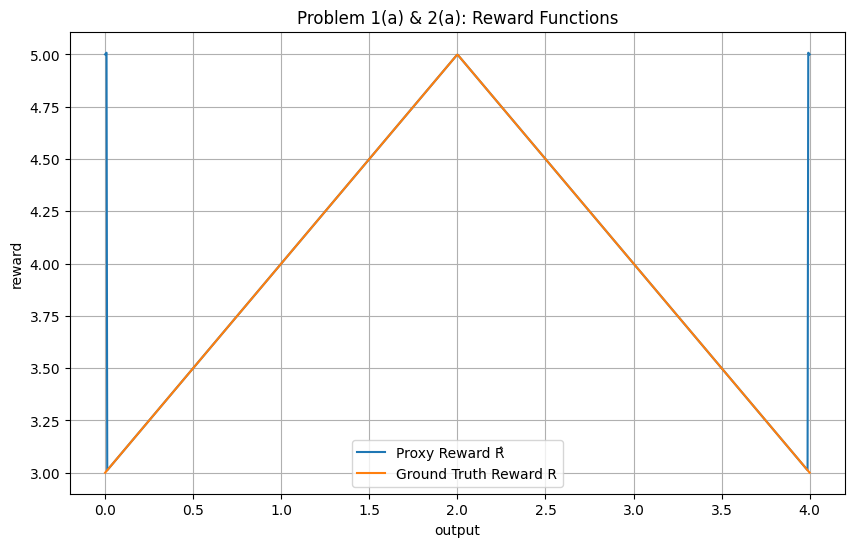

In [18]:
def plot_rewards() -> None:
    outputs = np.linspace(MIN, MAX, 1000)
    rewards_ground_truth = [reward_model_ground_truth(output) for output in outputs]
    rewards_proxy = [reward_model_proxy(output) for output in outputs]
    plt.figure(figsize=(10, 6))
    plt.plot(outputs, rewards_proxy, alpha=1.0, label='Proxy Reward R̂')
    plt.plot(outputs, rewards_ground_truth, alpha=1.0, label='Ground Truth Reward R')
    plt.xlabel("output")
    plt.ylabel("reward")
    plt.legend()
    plt.title("Problem 1(a) & 2(a): Reward Functions")
    plt.grid(True)
    plt.show()

# Plot the proxy and ground truth rewards
plot_rewards()

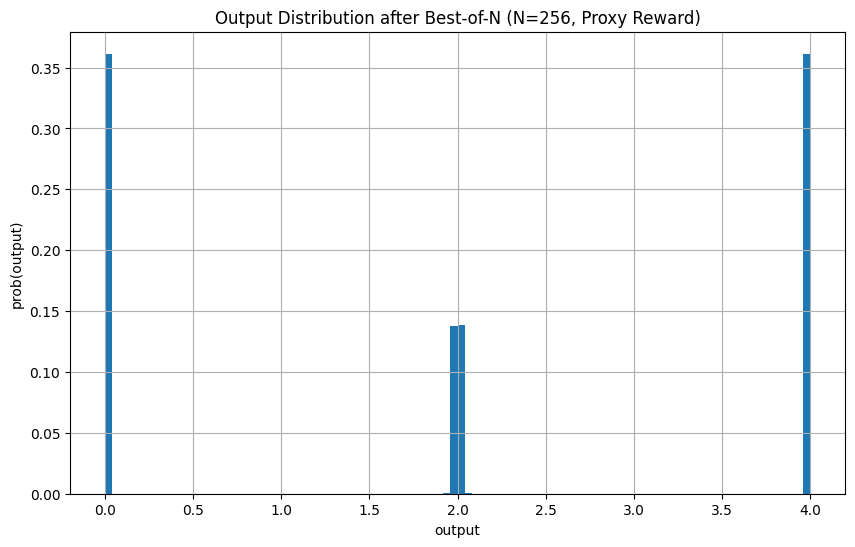

In [12]:
def best_of_n(n: int, reward_model):
    # Sample n outputs from the model
    samples = model(n)
    # Evaluate each sample with the reward model
    rewards = [reward_model(sample) for sample in samples]
    # Return the sample with highest reward and its reward
    best_idx = np.argmax(rewards)
    return samples[best_idx], rewards[best_idx]


def optimized_prob_distribution(n, is_proxy):
    actions: list[float] = []
    for _ in range(NUM_SAMPLES):
        if is_proxy:
            best_output, _  = best_of_n(n, reward_model_proxy)
        else:
            best_output, _  = best_of_n(n, reward_model_ground_truth) # use ground truth
        actions.append(best_output)
    probs, bins = histogram(actions)
    return probs, bins

# Probabilities before best-of-n sampling
probs_initial = BINS * [1/BINS]

# Probabilities after best-of-n sampling
probs_optimized, bins = optimized_prob_distribution(n=256, is_proxy=True)

def plot_optimized_output() -> None:
    plt.figure(figsize=(10, 6))
    plt.hist(bins[:-1], bins, weights=probs_optimized)
    plt.xlabel("output")
    plt.ylabel("prob(output)")
    plt.title("Output Distribution after Best-of-N (N=256, Proxy Reward)")
    plt.grid(True)
    plt.show()

# Plot the output after best-of-n sampling using the proxy reward model
plot_optimized_output()

In [19]:
# The KL divergence for best-of-n sampling can be computed analytically, see page 31 https://arxiv.org/pdf/2009.01325.pdf
def kl_divergence_analytical(n):
    # For best-of-n sampling from uniform distribution
    # KL(π_BoN || π_init) = log(n) - (n-1)/n
    return np.log(n) - (n - 1) / n


def kl_divergence_numerical(p, q):
    # KL(p || q) = sum(p * log(p / q))
    # Avoid division by zero and log(0)
    epsilon = 1e-10
    p = np.array(p) + epsilon
    q = np.array(q) + epsilon
    return np.sum(p * np.log(p / q))

# The KL divergence between the initial distribution and the optimized distribution increases with n
for n in [1, 2, 4, 8, 16, 32, 64]:
    kl_analytical = kl_divergence_analytical(n)
    print(f"n={n}, kl_divergence_analytical={kl_analytical:.4f}")

for n in [1, 2, 4, 8, 16, 32, 64]:
    probs_opt_temp, _ = optimized_prob_distribution(n, is_proxy=True)
    kl_numerical = kl_divergence_numerical(probs_opt_temp, probs_initial)
    print(f"n={n}, kl_divergence_numerical={kl_numerical:.4f}")

n=1, kl_divergence_analytical=0.0000
n=2, kl_divergence_analytical=0.1931
n=4, kl_divergence_analytical=0.6363
n=8, kl_divergence_analytical=1.2044
n=16, kl_divergence_analytical=1.8351
n=32, kl_divergence_analytical=2.4970
n=64, kl_divergence_analytical=3.1745
n=1, kl_divergence_numerical=0.0004
n=2, kl_divergence_numerical=0.1844
n=4, kl_divergence_numerical=0.6109
n=8, kl_divergence_numerical=1.1441
n=16, kl_divergence_numerical=1.7217
n=32, kl_divergence_numerical=2.2732
n=64, kl_divergence_numerical=2.7445


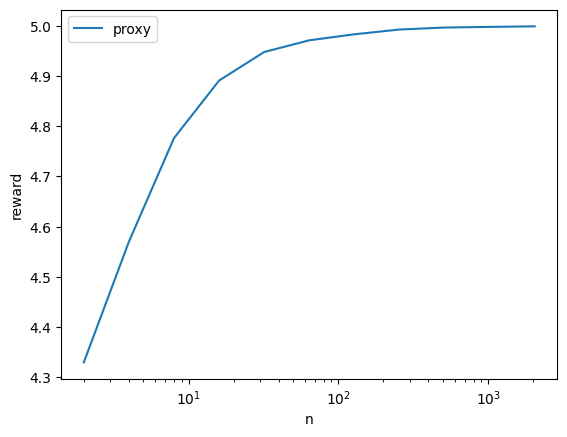

In [14]:
def estimate_reward(n, reward_model) -> float:
    total_reward = 0
    num_trials = 100
    for _ in range(num_trials):
        _, reward = best_of_n(n, reward_model)
        total_reward += reward
    return total_reward / num_trials

rewards_ground_truth = []

RANGE_N = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
for n in RANGE_N:
    reward_ground_truth = estimate_reward(n, reward_model_ground_truth)
    rewards_ground_truth.append(reward_ground_truth)

# Plot proxy vs. ground truth rewards
# With uniform random noise, the proxy as well as the ground truth reward are monotonically increasing
# But thats not the case when using a real instead of a toy reward model, see https://arxiv.org/pdf/2210.10760.pdf
plt.plot(RANGE_N, rewards_ground_truth)
plt.xscale('log')
plt.ylabel('reward')
plt.xlabel('n')
plt.legend(['proxy', 'ground truth'])
plt.show()

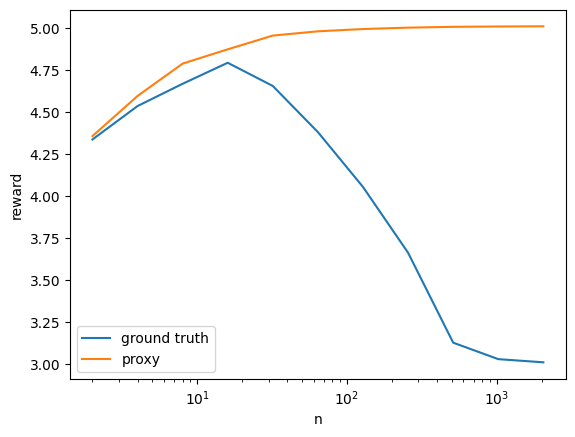

In [15]:
# why not using very large n?


def estimate_reward(n, reward_model_proxy) -> float:
    """
    Use proxy reward to select best sample, then evaluate with both proxy and ground truth.
    This simulates the reward hacking scenario.
    """
    total_reward_proxy = 0
    total_reward_gt = 0
    num_trials = 100
    for _ in range(num_trials):
        # Use proxy reward to select best sample (this is what the algorithm does)
        best_output, reward_proxy = best_of_n(n, reward_model_proxy)
        # Evaluate the selected sample with ground truth (this is what we actually care about)
        reward_gt = reward_model_ground_truth(best_output)
        
        total_reward_proxy += reward_proxy
        total_reward_gt += reward_gt
    return total_reward_proxy / num_trials, total_reward_gt / num_trials

rewards_ground_truth = []
rewards_proxy = []

RANGE_N = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
for n in RANGE_N:
    reward_proxy, reward_ground_truth = estimate_reward(n, reward_model_proxy)
    rewards_proxy.append(reward_proxy)
    rewards_ground_truth.append(reward_ground_truth)

# Plot proxy vs. ground truth rewards
# With uniform random noise, the proxy as well as the ground truth reward are monotonically increasing
# But thats not the case when using a real instead of a toy reward model, see https://arxiv.org/pdf/2210.10760.pdf
plt.plot(RANGE_N, rewards_ground_truth)
plt.plot(RANGE_N, rewards_proxy)
plt.xscale('log')
plt.ylabel('reward')
plt.xlabel('n')
plt.legend(['ground truth', 'proxy'])
plt.show()